### ***Goal of this notebook:***
#### The purpose of this notebook is to show the functions to evaluate the centering efficiency of the cluster finder. It is designed to associate the halos in cosmoDC2 and the clusters detected by redMaPPer in cosmoDC2, but can be tuned to work with other catalogues. 

In [1]:
import GCRCatalogs

import esutil
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

from cluster_validation.opening_catalogs_functions import *
from cluster_validation.association_methods import *
from cluster_validation.plotting_functions import *
from cluster_validation.association_statistics import *

%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
#plt.rcParams['figure.figsize'] = [10, 8] for big figures

/pbs/home/m/mricci/.local/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
plt.rcParams.update({'font.size': 18})

# 0 - opening catalogs

In [3]:
#function to open truth and detection catalogs

RM_cat_name = 'cosmoDC2_v1.1.4_redmapper_v0.2.1py'
DC2_cat_name = 'cosmoDC2_v1.1.4'          

min_richness = 20
min_halo_mass = 1e14 #Msun

cluster_data, member_data, truth_data, gc, gc_truth = RM_DC2_cat_open(RM_cat_name,DC2_cat_name,min_richness, min_halo_mass, cluster_only=False)

#take only the halo
halo_data = truth_data[truth_data['is_central']==True]

In [4]:
#define same cosmological parameters as in the truth catalog (cosmoDC2)
cosmo = gc_truth.cosmology

# 1 - basic visualization

### Number of halos and redMaPPer clusters as a function of redshift and mass or richness

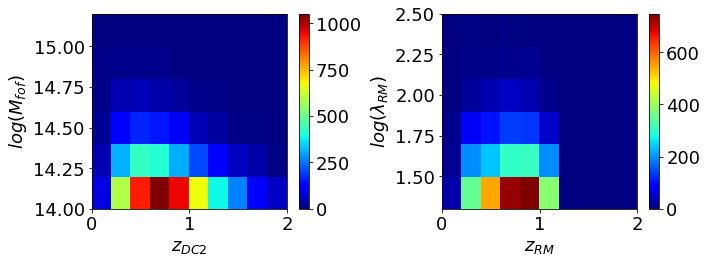

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

#number of true halos
bin_range = [[0,2],[14.,15.2]]
bins = [10,6]
num_min=20.

hist_num_halo = ax1.hist2d(halo_data['redshift'],np.log10(halo_data['halo_mass']),range=bin_range, bins= bins,cmap='jet')
fig.colorbar(hist_num_halo[3] , ax=ax1)
ax1.set_xlabel('$z_{DC2}$')
ax1.set_ylabel('$log(M_{fof})$')


#total number of redmapper detections
#bin_range2 = [[0,1.2],[1.3,2.5]]
bin_range2 = [[0,2],[1.3,2.5]]
bins2 = [10,6]

hist_num_det = ax2.hist2d(cluster_data['redshift'],np.log10(cluster_data['richness']),range=bin_range2, bins= bins2,cmap='jet');
fig.colorbar(hist_num_det[3] , ax=ax2)
ax2.set_xlabel('$z_{RM}$')
ax2.set_ylabel('$log(\lambda_{RM})$');

fig.tight_layout()

# 2 - associate redMaPPer detections to true DC2 halos

### - example association criteria : highest common membership within a cylinder with $\Delta_z=0.05, \theta_{max} = 1 Mpc$ 

In [6]:
#criteria
delta_zmax = 0.05
theta_max = 1. #Mpc
theta_max_type = "fixed_dist"
method = "membership"

match_num_1w, match_num_2w, ind_bij = \
volume_match(halo_data, cluster_data, delta_zmax, theta_max, theta_max_type, method, cosmo, truth_data, member_data)
#truth_to_det_match_numbers, det_to_truth_match_number, bijective_match_indices

In [7]:
#statistics
print ("number of bijective associations", number_of_associations(ind_bij))
print ("number and fraction of fragmentation", fragmentation(match_num_1w, ind_bij, method="bij"))
print ("number and fraction of overmerging", overmerging(match_num_2w, ind_bij, method="bij"))
print ("completeness", completeness(halo_data, ind_bij, gc, gc_truth))
print ("purity", purity(cluster_data, ind_bij,  gc, gc_truth))

number of bijective associations 3551
number and fraction of fragmentation (7, 0.0019712756969867645)
number and fraction of overmerging (150, 0.042241622078287806)
completeness 0.4399157582670904
purity 0.7447567114093959


# 3 - Compute and plot centering

In [8]:
#association of DC2 centrals to Redmapper centrals
ind_centered = np.argwhere(cluster_data['id_cen_0'][ind_bij[:,0]] == halo_data['galaxy_id'][ind_bij[:,1]])[:,0]
ind_not_centered = np.argwhere(cluster_data['id_cen_0'][ind_bij[:,0]] != halo_data['galaxy_id'][ind_bij[:,1]])[:,0]

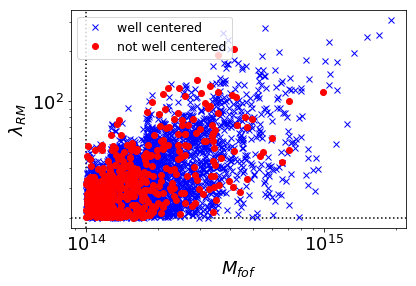

In [9]:
fig,ax = plot_richness_mass(halo_data, cluster_data, ind_bij, zmin = 0, zmax = np.inf, min_richness=min_richness, min_halo_mass=min_halo_mass, fmt='w.')

ax.loglog(halo_data['halo_mass'][ind_bij[:,1]][ind_centered],cluster_data['richness'][ind_bij[:,0]][ind_centered],'bx', label = 'well centered')
ax.loglog(halo_data['halo_mass'][ind_bij[:,1]][ind_not_centered],cluster_data['richness'][ind_bij[:,0]][ind_not_centered],'ro', label = 'not well centered')

plt.legend(fontsize='x-small')

In [22]:
bin_range = [[0,1.2],[14.,15.2]]
bins = [6,6]

cent_2d, cent_2d_mask = centering_2d(halo_data, ind_bij, ind_centered, bin_range = bin_range, bins = bins, nmin=10, ref_cat='DC2') 

Text(0, 0.5, '$log(M_{fof})$')

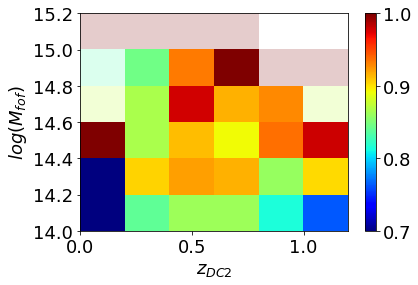

In [23]:
fig, ax = plt.subplots(1,1)

vmin = 0.7
ax.imshow(cent_2d.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin,vmax=1,cmap='jet',alpha=0.2);
im = ax.imshow(cent_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{DC2}$')
ax.set_ylabel('$log(M_{fof})$')

In [12]:
bin_range = [[0,1.2],[1.3,2.5]]
bins = [6,6]

cent_2d, cent_2d_mask = centering_2d(cluster_data, ind_bij, ind_centered, bin_range = bin_range, bins = bins, nmin=10, ref_cat='RM') 

Text(0, 0.5, '$log(\\lambda_{RM})$')

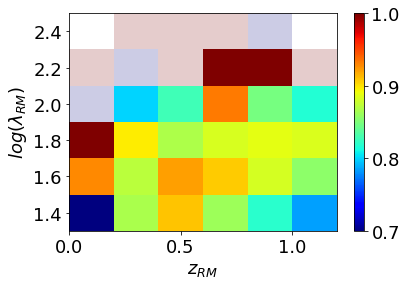

In [13]:
fig, ax = plt.subplots(1,1)

vmin = 0.7
ax.imshow(cent_2d.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin,vmax=1,cmap='jet',alpha=0.2);
im = ax.imshow(cent_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{RM}$')
ax.set_ylabel('$log(\lambda_{RM})$')